In [1]:
# Covid19 Analysis


In [2]:
# libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
import pickle
from sklearn.metrics import r2_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from xgboost import XGBClassifier
from haversine import haversine, Unit
from haversine import haversine_vector

/home/pedro/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# reading dataset
# https://opendatasus.saude.gov.br/dataset/bd-srag-2020

df = pd.read_csv('/home/pedro/Desktop/code/dataset/INFLUD-21-09-2020.csv',sep=';',encoding = "ISO-8859-1")

# Inputing constraint in the dataset 

# Positive case:

df = df[df['PCR_SARS2']==1]
print(df.shape)


# Hospitalized people:

df = df[df['PCR_SARS2']==1][df['HOSPITAL']==1][df['NU_IDADE_N']<=110]
print(df.shape)

# Hospitalized people with age small than 110:

df = df[df['PCR_SARS2']==1][df['HOSPITAL']==1][df['NU_IDADE_N']<=110][df['EVOLUCAO'] != 3][df['EVOLUCAO'] != 9][df['EVOLUCAO'].notnull()]
print(df.shape)


/home/pedro/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (15,60,62,63,64,92,94,108,117,121,123) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(299142, 154)


/home/pedro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(279982, 154)


/home/pedro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(242679, 154)


In [4]:
# Latitudes and longitudes table from municipalities

df_cod = pd.read_csv('/home/pedro/Desktop/code/dataset/municipios.csv', sep=',')


In [5]:
# Removing last number from "codenumber"

df_cod['CO_MUN_RES'] = df_cod['CO_MUN_RES'].astype(str).str[:-1].astype(np.int64)
df_cod['CO_MU_INTE'] = df_cod['CO_MU_INTE'].astype(str).str[:-1].astype(np.int64)

In [6]:
# To match catalogues using muninipacity code
# latitude and longitude for pacient residence


result_01 = pd.merge(df, df_cod[['CO_MUN_RES','latitude_res','longitude_res']], on='CO_MUN_RES', how="left")
result_02 = pd.merge(df, df_cod[['CO_MU_INTE','latitude_int','longitude_int']], on='CO_MU_INTE', how="left") 

print(result_01.shape)
print(result_02.shape)

(242679, 156)
(242679, 156)


In [7]:
# To transforming in tuple

patient_mun_code  = result_01[['latitude_res','longitude_res']].to_numpy()
hospital_mun_code = result_02[['latitude_int','longitude_int']].to_numpy()


print(patient_mun_code.shape)
print(hospital_mun_code.shape)

(242679, 2)
(242679, 2)


In [8]:
# To calculate the distance from patient to hospital (difference between municipalities centers in km)

df['distance'] = haversine_vector(patient_mun_code, hospital_mun_code, Unit.KILOMETERS)

In [9]:
# To check

print(df[['CO_MUN_RES','CO_MU_INTE','ID_MUNICIP', 'distance']])

        CO_MUN_RES  CO_MU_INTE     ID_MUNICIP    distance
7         351880.0    355030.0      SAO PAULO   13.951736
9         350570.0    355030.0      SAO PAULO   24.605443
10        355030.0    355030.0      SAO PAULO    0.000000
12        352670.0    352670.0           LEME    0.000000
18        355030.0    355030.0      SAO PAULO    0.000000
...            ...         ...            ...         ...
754858    330630.0    330630.0  VOLTA REDONDA    0.000000
754875    317020.0    317020.0     UBERLANDIA    0.000000
754892    291110.0    290320.0      BARREIRAS  125.383634
754896    230640.0    230440.0      FORTALEZA  118.057231
754897    330070.0    330070.0      CABO FRIO    0.000000

[242679 rows x 4 columns]


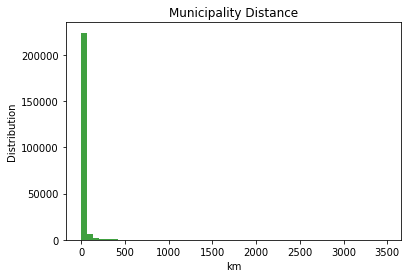

In [10]:
# Histogram for Municipality Distance

plt.hist(df['distance'], 50, density=False, facecolor='g', alpha=0.75) # .dropna(),
plt.xlabel('km')
plt.ylabel('Distribution')
plt.title('Municipality Distance')
plt.show()

In [11]:
# To check long distances

print(df[['CO_MUN_RES','CO_MU_INTE','ID_MUNICIP', 'distance']][df['distance']>3000])

        CO_MUN_RES  CO_MU_INTE        ID_MUNICIP     distance
136401    431680.0    261160.0            RECIFE  3027.037343
200859    140010.0    420910.0         JOINVILLE  3479.593208
299138    421565.0    150405.0        MAE DO RIO  3019.144779
373144    110070.0    261160.0            RECIFE  3166.007414
509610    120020.0    310620.0    BELO HORIZONTE  3383.789594
573760    211120.0    430300.0  CACHOEIRA DO SUL  3195.009539
616802    260290.0    431440.0           PELOTAS  3165.723955
655586    160060.0    430910.0           GRAMADO  3261.277507
693063    431490.0    240800.0           MOSSORO  3121.907328
696975    140010.0    355030.0         SAO PAULO  3301.511571


In [12]:
print(df['distance'].max())
print(df[['CO_MUN_RES','CO_MU_INTE','ID_MUNICIP', 'distance']][df['distance']>3479])                            

# Bigger distance  Boa Vista (Roraima) to Joinville (Santa Catarina)

3479.593208186318
        CO_MUN_RES  CO_MU_INTE ID_MUNICIP     distance
200859    140010.0    420910.0  JOINVILLE  3479.593208


In [13]:
# overcrowded dataset
# dataset with code from hospital (cnes) with epidemiology week and the overcrowded status of hospital.

df_cod = pd.read_csv('/home/pedro/Desktop/code/dataset/hospital_overcrowded.csv', sep=',')

# CO_UNI_NOT, SEM_NOT, Overcrowded

# Overload = number of hospitalization in epidemiological week for COVID-19 / 2019 sum hospital hospitalization by SARS

In [14]:
# To check

df = pd.merge(df, df_cod, on=['CO_UNI_NOT', 'SEM_NOT'], how="left")
print(df.shape)

(242679, 156)


In [15]:
# Municipalities number inicial

# patient municipality code number
print(len(df['CO_MUN_NOT']))

# reporting health unit code number
print(len(df['CO_UNI_NOT']))


print(df['CO_MUN_NOT'].nunique())
print(df['CO_MUN_RES'].nunique())

242679
242679
1814
4401


In [16]:
# IDHM

# Reading IBGE code for each municipalities and separating it for IDHM index

df_atlas = pd.read_excel (r'/home/pedro/Desktop/code/dataset/AtlasBrasil_Consulta.xlsx')


# removind last interger in 'code' variable

df_atlas['code'] = df_atlas['code'].astype(str).str[:-1].astype(np.int64)


# Divinding IDHM in bins

IDHM_veryhigh  =  set(df_atlas['code'][df_atlas['IDHM2010']>=0.800])
print(len(IDHM_veryhigh))


IDHM_high  =  set(df_atlas['code'][((df_atlas['IDHM2010']>=0.700)&(df_atlas['IDHM2010']<0.800))])
print(len(IDHM_high))


IDHM_medium  =  set(df_atlas['code'][((df_atlas['IDHM2010']>=0.600)&(df_atlas['IDHM2010']<0.700))])
print(len(IDHM_medium))


IDHM_low  =  set(df_atlas['code'][((df_atlas['IDHM2010']>=0.500)&(df_atlas['IDHM2010']<0.600))])
print(len(IDHM_low))


IDHM_verylow  =  set(df_atlas['code'][df_atlas['IDHM2010']<0.500])
print(len(IDHM_verylow))




df.loc[df['CO_MUN_NOT'].isin(IDHM_veryhigh) == True, 'IDHM'] = 5
df.loc[df['CO_MUN_NOT'].isin(IDHM_high) == True, 'IDHM'] = 4
df.loc[df['CO_MUN_NOT'].isin(IDHM_medium) == True, 'IDHM'] = 3
df.loc[df['CO_MUN_NOT'].isin(IDHM_low) == True, 'IDHM'] = 2
df.loc[df['CO_MUN_NOT'].isin(IDHM_verylow) == True, 'IDHM'] = 1


44
1890
2233
1367
32


In [17]:
# Private and public hospital separation

df_hospital = pd.read_csv('/home/pedro/Desktop/code/dataset/CNES_SUS.txt', sep='\t')


public   =  set(df_hospital.iloc[:,0][df_hospital.iloc[:,3]=='S'])
private  =  set(df_hospital.iloc[:,0][df_hospital.iloc[:,3]=='N'])


df.loc[df['CO_UNI_NOT'].isin(public) == True, 'HEALTH_SYSTEM'] = 1
df.loc[df['CO_UNI_NOT'].isin(private) == True, 'HEALTH_SYSTEM'] = 0

# CO_UNI_NOT

In [18]:
# Constraint on dataset: We only analyze people with evolution, IDHM and Health system outcomes

df = df[df['IDHM'].notnull()][(df['HEALTH_SYSTEM']==1)|(df['HEALTH_SYSTEM']==0)]
print(df.shape)

/home/pedro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


(231112, 158)


In [19]:
# Municipalities number

print(len(df['CO_MUN_NOT']))
print(len(df['CO_MU_INTE']))

print(df['CO_MUN_NOT'].nunique())
print(df['CO_MU_INTE'].nunique())


231112
231112
1801
1766


In [20]:
# To selecting features and target

df = df[['Overload', 'distance','NU_IDADE_N','CS_SEXO','IDHM','CS_RACA','CS_ESCOL_N','SG_UF_NOT','CS_ZONA',\
'HEALTH_SYSTEM','CS_GESTANT','FEBRE','VOMITO','TOSSE','GARGANTA','DESC_RESP','DISPNEIA','DIARREIA',\
'SATURACAO','CARDIOPATI','HEPATICA','ASMA','PNEUMOPATI','RENAL','HEMATOLOGI','DIABETES',\
'OBESIDADE','NEUROLOGIC','IMUNODEPRE','EVOLUCAO']]

In [21]:
# adding comorbidities

df['SUM_COMORBIDITIES'] = df.iloc[:,19:-1].replace([9,2], 0).fillna(0).sum(axis=1)
df['SUM_SYMPTOMS'] = df.iloc[:,11:17].replace([9,2], 0).fillna(0).sum(axis=1)


In [22]:
# Ordering features

df = df[['Overload', 'distance','NU_IDADE_N','CS_SEXO','IDHM','SUM_COMORBIDITIES','SUM_SYMPTOMS',\
'CS_RACA','CS_ESCOL_N','SG_UF_NOT','CS_ZONA','HEALTH_SYSTEM','CS_GESTANT','FEBRE','VOMITO','TOSSE',\
'GARGANTA','DESC_RESP','DISPNEIA','DIARREIA','SATURACAO','CARDIOPATI','HEPATICA','ASMA','PNEUMOPATI',\
'RENAL','HEMATOLOGI','DIABETES','OBESIDADE','NEUROLOGIC','IMUNODEPRE','EVOLUCAO']]

In [23]:
# Pre-Processing

df = df[df['EVOLUCAO'].notnull()][df['EVOLUCAO']!=9][df['EVOLUCAO']!=3]#[df_BR['NU_IDADE_N'].notnull()]
df['CS_SEXO']=df['CS_SEXO'].replace({'M': 1, 'F':0, 'I':9, 'NaN':np.nan})


# replacing 2 by 0 (Death patients)
df.iloc[:,13:] = df.iloc[:,13:].replace(to_replace = 2.0, value =0) 


df['SG_UF_NOT'] = df['SG_UF_NOT'].map({'SP': 0, 'RJ':1, 'MG': 2 , 'ES':3, \
'RS':4, 'SC': 5, 'PR': 6, 'MT': 7, 'MS': 8, 'GO':9, 'DF':10, 'RO':11,'AC':12,'AM':13,\
'RR':14,'PA':15,'AP':16,'TO':17,'MA':18,'PI':19,'BA':20,'CE':21,'RN':22,'PB':23,'PE':24,'AL':25,'SE':26})

# For missing values in comorbidities and symptoms we filled by 0.
df.iloc[:,13:-1] = df.iloc[:,13:-1].fillna(0)

In [24]:
# feature
x = df.iloc[:,:-1]

# labels
y = df['EVOLUCAO']

In [25]:
# data separation
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.2, random_state=5)


In [26]:
print(y_train.shape)
print(y_test.shape)

(184889,)
(46223,)


In [27]:
params = params = {'booster ':['gbtree'],
        'n_estimators': [200],          
        'eta':[0.2],    
        'max_depth':[4],
        'gamma': [1],
        'subsample': [0.9],
        'colsample_bytree': [0.9],
            }


                            
                            
xgb = XGBClassifier()
gs = GridSearchCV(estimator=xgb, param_grid=params, return_train_score=True, cv=10, scoring='roc_auc') 


gs = gs.fit(x_train, y_train)


print(gs.best_score_)
print(gs.best_params_)


print(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['std_test_score'])

print(gs.cv_results_['mean_train_score'])   
print(gs.cv_results_['std_train_score'])   



clf = gs.best_estimator_
clf.fit(x_train, y_train)


# save the model to disk
filename_nn = 'xgb_with_symptoms.sav'
pickle.dump(clf, open(filename_nn, 'wb')) 

[00:20:15] WARNING: /workspace/src/learner.cc:480: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:20:31] WARNING: /workspace/src/learner.cc:480: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:20:48] WARNING: /workspace/src/learner.cc:480: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above c

In [28]:
# load the model from disk
loaded_model_xgb = pickle.load(open('xgb_with_symptoms.sav', 'rb'))

In [29]:
# To predicting 
xgb_pred = loaded_model_xgb.predict_proba(x_test)

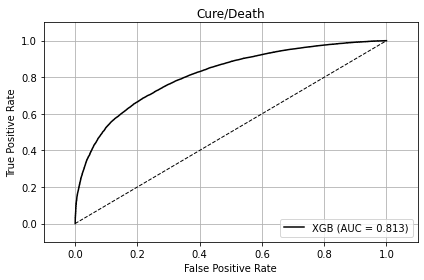

In [30]:
# Plot Roc Curve

colors = ['blue']
linestyles = ['--']
#plt.figure(figsize=(5,5))
fpr, tpr, thresholds = roc_curve(y_test, xgb_pred[:,1],pos_label=1)
roc_auc = auc(x=fpr, y=tpr)
plt.plot(fpr, tpr,
             color='k',
             linestyle='-',
             label='%s (AUC = %0.3f)' % ('XGB', roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='black',
         linewidth=1)

plt.title('')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.title('Cure/Death')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.tight_layout()
#plt.savefig('roc_xgb_public_private_without_symptoms.pdf')
plt.show()  

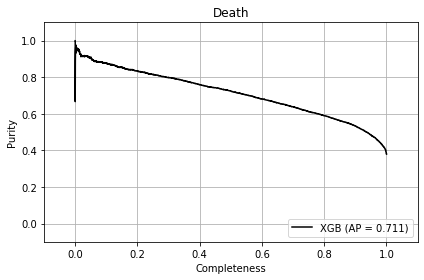

In [31]:
# Plot Purity x Completeness 


precision, recall, thresholds = precision_recall_curve(y_test, xgb_pred[:,0],pos_label=0)
average_precision = average_precision_score(1-y_test, xgb_pred[:,0])
plt.plot(recall, precision, color='k',linestyle='-',label='%s (AP = %0.3f)' % ('XGB', average_precision))

plt.legend(loc='lower right')


plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('Completeness')
plt.ylabel('Purity')
plt.title('Death')
plt.tight_layout()
plt.show()  

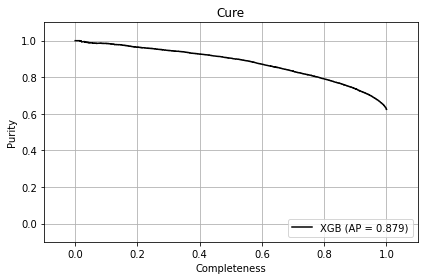

In [32]:
# Plot Purity x Completeness 


precision, recall, thresholds = precision_recall_curve(y_test, xgb_pred[:,1],pos_label=1)
average_precision = average_precision_score(y_test, xgb_pred[:,1])
plt.plot(recall, precision, color='k',linestyle='-',label='%s (AP = %0.3f)' % ('XGB', average_precision))

plt.legend(loc='lower right')


plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('Completeness')
plt.ylabel('Purity')
plt.title('Cure')
plt.tight_layout()
plt.show()  

In [33]:
wordList = ['FEBRE','VOMITO','TOSSE','GARGANTA','DESC_RESP','DISPNEIA','DIARREIA','SATURACAO',\
'CARDIOPATI','HEPATICA','ASMA','PNEUMOPATI','RENAL','HEMATOLOGI','DIABETES','OBESIDADE',\
'NEUROLOGIC','IMUNODEPRE']



for word in wordList:
    pred = loaded_model_xgb.predict_proba(x_test[x_test[word]==1])
       
    fpr, tpr, thresholds = roc_curve(y_test[x_test[word]==1], pred[:,1], pos_label=1)
    pred_auc = auc(x=fpr, y=tpr)
    
    
    print('%s (AUC = %0.3f), number of data %d' % (word, pred_auc, y_test[x_test[word]==1].shape[0]) )

FEBRE (AUC = 0.813), number of data 30650
VOMITO (AUC = 0.810), number of data 3653
TOSSE (AUC = 0.808), number of data 33955
GARGANTA (AUC = 0.821), number of data 8268
DESC_RESP (AUC = 0.803), number of data 26473
DISPNEIA (AUC = 0.802), number of data 33066
DIARREIA (AUC = 0.811), number of data 6384
SATURACAO (AUC = 0.787), number of data 27239
CARDIOPATI (AUC = 0.767), number of data 16294
HEPATICA (AUC = 0.731), number of data 441
ASMA (AUC = 0.810), number of data 1227
PNEUMOPATI (AUC = 0.746), number of data 1892
RENAL (AUC = 0.719), number of data 2166
HEMATOLOGI (AUC = 0.804), number of data 400
DIABETES (AUC = 0.758), number of data 12132
OBESIDADE (AUC = 0.771), number of data 2323
NEUROLOGIC (AUC = 0.727), number of data 1985
IMUNODEPRE (AUC = 0.741), number of data 1449


In [34]:
# Gender

# Male
pred_male = loaded_model_xgb.predict_proba(x_test[x_test['CS_SEXO']==1])
fpr_male, tpr_male, thresholds_male = roc_curve(y_test[x_test['CS_SEXO']==1], pred_male[:,1], pos_label=1)
pred_auc_male = auc(x=fpr_male, y=tpr_male)


# Female
pred_female = loaded_model_xgb.predict_proba(x_test[x_test['CS_SEXO']==0])
fpr_female, tpr_female, thresholds_female = roc_curve(y_test[x_test['CS_SEXO']==0], pred_female[:,1], pos_label=1)
pred_auc_female = auc(x=fpr_female, y=tpr_female)
    
    
print('Male AUC = %0.3f, number of data %d' % (pred_auc_male, y_test[x_test['CS_SEXO']==1].shape[0]) )
print('Female AUC = %0.3f, number of data %d' % (pred_auc_female, y_test[x_test['CS_SEXO']==0].shape[0]) )

Male AUC = 0.815, number of data 26131
Female AUC = 0.811, number of data 20081


In [35]:
# Hospital unit reporting  

# public
pred_public = loaded_model_xgb.predict_proba(x_test[x_test['HEALTH_SYSTEM']==1])
fpr_public, tpr_public, thresholds_public = roc_curve(y_test[x_test['HEALTH_SYSTEM']==1], pred_public[:,1], pos_label=1)
pred_auc_public = auc(x=fpr_public, y=tpr_public)


# private
pred_private = loaded_model_xgb.predict_proba(x_test[x_test['HEALTH_SYSTEM']==0])
fpr_private, tpr_private, thresholds_private = roc_curve(y_test[x_test['HEALTH_SYSTEM']==0], pred_private[:,1], pos_label=1)
pred_auc_private = auc(x=fpr_private, y=tpr_private)
    
    
print('Public AUC = %0.3f, number of data %d' % (pred_auc_public, y_test[x_test['HEALTH_SYSTEM']==1].shape[0]) )
print('Private AUC = %0.3f, number of data %d' % (pred_auc_private, y_test[x_test['HEALTH_SYSTEM']==0].shape[0]) )

Public AUC = 0.799, number of data 36603
Private AUC = 0.843, number of data 9620


In [36]:
# Pregancy

# pregnant
pred_pregnant = loaded_model_xgb.predict_proba(x_test[(x_test['CS_GESTANT']==1)|(x_test['CS_GESTANT']==2)|(x_test['CS_GESTANT']==3)|(x_test['CS_GESTANT']==4)])
fpr_pregnant, tpr_pregnant, thresholds_pregnant = roc_curve(y_test[(x_test['CS_GESTANT']==1)|(x_test['CS_GESTANT']==2)|(x_test['CS_GESTANT']==3)|(x_test['CS_GESTANT']==4)], pred_pregnant[:,1], pos_label=1)
pred_auc_pregnant = auc(x=fpr_pregnant, y=tpr_pregnant)


# non-pregnant
pred_non_preg = loaded_model_xgb.predict_proba(x_test[x_test['CS_GESTANT']==5])
fpr_non_preg, tpr_non_preg, thresholds_non_preg = roc_curve(y_test[x_test['CS_GESTANT']==5], pred_non_preg[:,1], pos_label=1)
pred_auc_non_preg = auc(x=fpr_non_preg, y=tpr_non_preg)
    
    
print('Pregnant AUC = %0.3f, number of data %d' % (pred_auc_pregnant, y_test[(x_test['CS_GESTANT']==1)|(x_test['CS_GESTANT']==2)|(x_test['CS_GESTANT']==3)|(x_test['CS_GESTANT']==4)].shape[0]) )
print('Non-pregnant AUC = %0.3f, number of data %d' % (pred_auc_non_preg, y_test[x_test['CS_GESTANT']==5].shape[0]) )

Pregnant AUC = 0.742, number of data 409
Non-pregnant AUC = 0.809, number of data 14286


In [37]:
# Color

# branco
pred_branco = loaded_model_xgb.predict_proba(x_test[x_test['CS_RACA']==1])
fpr_branco, tpr_branco, thresholds_branco = roc_curve(y_test[x_test['CS_RACA']==1], pred_branco[:,1], pos_label=1)
pred_auc_branco = auc(x=fpr_branco, y=tpr_branco)


# preto
pred_preto = loaded_model_xgb.predict_proba(x_test[x_test['CS_RACA']==2])
fpr_preto, tpr_preto, thresholds_preto = roc_curve(y_test[x_test['CS_RACA']==2], pred_preto[:,1], pos_label=1)
pred_auc_preto = auc(x=fpr_preto, y=tpr_preto)



# amarelo
pred_amarelo = loaded_model_xgb.predict_proba(x_test[x_test['CS_RACA']==3])
fpr_amarelo, tpr_amarelo, thresholds_amarelo = roc_curve(y_test[x_test['CS_RACA']==3], pred_amarelo[:,1], pos_label=1)
pred_auc_amarelo = auc(x=fpr_amarelo, y=tpr_amarelo)
  
    
    
# pardo
pred_pardo = loaded_model_xgb.predict_proba(x_test[x_test['CS_RACA']==4])
fpr_pardo, tpr_pardo, thresholds_pardo = roc_curve(y_test[x_test['CS_RACA']==4], pred_pardo[:,1], pos_label=1)
pred_auc_pardo = auc(x=fpr_pardo, y=tpr_pardo)
  
    
    
# indigena
pred_indigena = loaded_model_xgb.predict_proba(x_test[x_test['CS_RACA']==5])
fpr_indigena, tpr_indigena, thresholds_indigena = roc_curve(y_test[x_test['CS_RACA']==5], pred_indigena[:,1], pos_label=1)
pred_auc_indigena = auc(x=fpr_indigena, y=tpr_indigena)
      
    
    
print('Branco AUC = %0.3f, number of data %d' % (pred_auc_branco, y_test[x_test['CS_RACA']==1].shape[0]) )
print('Preto AUC = %0.3f, number of data %d' % (pred_auc_preto, y_test[x_test['CS_RACA']==2].shape[0]) )
print('Amarelo AUC = %0.3f, number of data %d' % (pred_auc_amarelo, y_test[x_test['CS_RACA']==3].shape[0]) )
print('Pardo AUC = %0.3f, number of data %d' % (pred_auc_pardo, y_test[x_test['CS_RACA']==4].shape[0]) )
print('Indigena AUC = %0.3f, number of data %d' % (pred_auc_indigena, y_test[x_test['CS_RACA']==5].shape[0]) )


Branco AUC = 0.813, number of data 17186
Preto AUC = 0.803, number of data 2293
Amarelo AUC = 0.789, number of data 519
Pardo AUC = 0.804, number of data 13556
Indigena AUC = 0.891, number of data 98


In [38]:
# Education

# Illiterate
pred_illiterate = loaded_model_xgb.predict_proba(x_test[x_test['CS_ESCOL_N']==0])
fpr_illiterate, tpr_illiterate, thresholds_illiterate = roc_curve(y_test[x_test['CS_ESCOL_N']==0], pred_illiterate[:,1], pos_label=1)
pred_auc_illiterate = auc(x=fpr_illiterate, y=tpr_illiterate)


# Fundamental I
pred_fundI = loaded_model_xgb.predict_proba(x_test[x_test['CS_ESCOL_N']==1])
fpr_fundI, tpr_fundI, thresholds_fundI = roc_curve(y_test[x_test['CS_ESCOL_N']==1], pred_fundI[:,1], pos_label=1)
pred_auc_fundI = auc(x=fpr_fundI, y=tpr_fundI)



# Fundamental II
pred_fundII = loaded_model_xgb.predict_proba(x_test[x_test['CS_ESCOL_N']==2])
fpr_fundII, tpr_fundII, thresholds_fundII = roc_curve(y_test[x_test['CS_ESCOL_N']==2], pred_fundII[:,1], pos_label=1)
pred_auc_fundII = auc(x=fpr_fundII, y=tpr_fundII)
  
    
    
# Medium
pred_medium = loaded_model_xgb.predict_proba(x_test[x_test['CS_ESCOL_N']==3])
fpr_medium, tpr_medium, thresholds_medium = roc_curve(y_test[x_test['CS_ESCOL_N']==3], pred_medium[:,1], pos_label=1)
pred_auc_medium = auc(x=fpr_medium, y=tpr_medium)
  
    
    
# University
pred_university = loaded_model_xgb.predict_proba(x_test[x_test['CS_ESCOL_N']==4])
fpr_university, tpr_university, thresholds_university = roc_curve(y_test[x_test['CS_ESCOL_N']==4], pred_university[:,1], pos_label=1)
pred_auc_university = auc(x=fpr_university, y=tpr_university)
      
    
    
print('Illiterate AUC = %0.3f, number of data %d' % (pred_auc_illiterate, y_test[x_test['CS_ESCOL_N']==0].shape[0]) )
print('Fundamental I AUC = %0.3f, number of data %d' % (pred_auc_fundI, y_test[x_test['CS_ESCOL_N']==1].shape[0]) )
print('Fundamental II AUC = %0.3f, number of data %d' % (pred_auc_fundII, y_test[x_test['CS_ESCOL_N']==2].shape[0]) )
print('Medium AUC = %0.3f, number of data %d' % (pred_auc_medium, y_test[x_test['CS_ESCOL_N']==3].shape[0]) )
print('University AUC = %0.3f, number of data %d' % (pred_auc_university, y_test[x_test['CS_ESCOL_N']==4].shape[0]) )


Illiterate AUC = 0.762, number of data 1042
Fundamental I AUC = 0.773, number of data 4315
Fundamental II AUC = 0.808, number of data 3090
Medium AUC = 0.828, number of data 5157
University AUC = 0.874, number of data 2523


In [39]:
# Area

# Urban
pred_urban = loaded_model_xgb.predict_proba(x_test[x_test['CS_ZONA']==1])
fpr_urban, tpr_urban, thresholds_urban = roc_curve(y_test[x_test['CS_ZONA']==1], pred_urban[:,1], pos_label=1)
pred_auc_urban = auc(x=fpr_urban, y=tpr_urban)


# Rural
pred_rural = loaded_model_xgb.predict_proba(x_test[x_test['CS_ZONA']==2])
fpr_rural, tpr_rural, thresholds_rural = roc_curve(y_test[x_test['CS_ZONA']==2], pred_rural[:,1], pos_label=1)
pred_auc_rural = auc(x=fpr_rural, y=tpr_rural)



# Peri-urban
pred_periurban = loaded_model_xgb.predict_proba(x_test[x_test['CS_ZONA']==3])
fpr_periurban, tpr_periurban, thresholds_periurban = roc_curve(y_test[x_test['CS_ZONA']==3], pred_periurban[:,1], pos_label=1)
pred_auc_periurban = auc(x=fpr_periurban, y=tpr_periurban)
  
         
    
    
print('Urban AUC = %0.3f, number of data %d' % (pred_auc_urban, y_test[x_test['CS_ZONA']==1].shape[0]) )
print('Rural AUC = %0.3f, number of data %d' % (pred_auc_rural, y_test[x_test['CS_ZONA']==2].shape[0]) )
print('Periurban AUC = %0.3f, number of data %d' % (pred_auc_periurban, y_test[x_test['CS_ZONA']==3].shape[0]) )


Urban AUC = 0.813, number of data 39777
Rural AUC = 0.798, number of data 1217
Periurban AUC = 0.795, number of data 143


In [40]:
# IDHM


# Very High
pred_veryhight = loaded_model_xgb.predict_proba(x_test[x_test['IDHM']==5])
fpr_veryhight, tpr_veryhight, thresholds_veryhight = roc_curve(y_test[x_test['IDHM']==5], pred_veryhight[:,1], pos_label=1)
pred_auc_veryhight = auc(x=fpr_veryhight, y=tpr_veryhight)


# High
pred_hight = loaded_model_xgb.predict_proba(x_test[x_test['IDHM']==4])
fpr_hight, tpr_hight, thresholds_hight = roc_curve(y_test[x_test['IDHM']==4], pred_hight[:,1], pos_label=1)
pred_auc_hight = auc(x=fpr_hight, y=tpr_hight)



# Medium Low
pred_mediumLow = loaded_model_xgb.predict_proba(x_test[((x_test['IDHM']==3)\
|(x_test['IDHM']==2)|(x_test['IDHM']==1))])

fpr_mediumLow, tpr_mediumLow, thresholds_mediumLow = roc_curve(y_test[((x_test['IDHM']==3)\
|(x_test['IDHM']==2)|(x_test['IDHM']==1))], pred_mediumLow[:,1], pos_label=1)
pred_auc_mediumLow = auc(x=fpr_mediumLow, y=tpr_mediumLow)
  
         
    
    
print('Very High AUC = %0.3f, number of data %d' % (pred_auc_veryhight, y_test[x_test['IDHM']==5].shape[0]) )
print('Highl AUC = %0.3f, number of data %d' % (pred_auc_hight, y_test[x_test['IDHM']==4].shape[0]) )
print('Medium Low AUC = %0.3f, number of data %d' % (pred_auc_mediumLow, y_test[((x_test['IDHM']==3)\
|(x_test['IDHM']==2)|(x_test['IDHM']==1))].shape[0]) )


Very High AUC = 0.816, number of data 18113
Highl AUC = 0.802, number of data 24989
Medium Low AUC = 0.791, number of data 3121


In [41]:
# Macroregions


# Macro Regions

northeast  =  set([18,19,20,21,22,23,24,25,26])
north  =  set([11,12,13,14,15,16,17])
midwest  =  set([7,8,9,10])
southeast  =  set([0,1,2,3])
south = set([4,5,6])

# To remember

#df_BR['SG_UF_NOT'] = df_BR['SG_UF_NOT'].map({'SP': 0, 'RJ':1, 'MG': 2 , 'ES':3, \
#'RS':4, 'SC': 5, 'PR': 6, 'MT': 7, 'MS': 8, 'GO':9, 'DF':10, 'RO':11,'AC':12,'AM':13,\
#'RR':14,'PA':15,'AP':16,'TO':17,'MA':18,'PI':19,'BA':20,'CE':21,'RN':22,'PB':23,'PE':24,'AL':25,'SE':26})


# North
pred_north = loaded_model_xgb.predict_proba(x_test[x_test['SG_UF_NOT'].isin(north)])
fpr_north, tpr_north, thresholds_north = roc_curve(y_test[x_test['SG_UF_NOT'].isin(north)], pred_north[:,1],\
pos_label=1)
pred_auc_north = auc(x=fpr_north, y=tpr_north)



# Northeast
pred_northeast = loaded_model_xgb.predict_proba(x_test[x_test['SG_UF_NOT'].isin(northeast)])
fpr_northeast, tpr_northeast, thresholds_northeast = roc_curve(y_test[x_test['SG_UF_NOT'].isin(northeast)], pred_northeast[:,1], pos_label=1)
pred_auc_northeast = auc(x=fpr_northeast, y=tpr_northeast)



# Midwest
pred_midwest = loaded_model_xgb.predict_proba(x_test[x_test['SG_UF_NOT'].isin(midwest)])
fpr_midwest, tpr_midwest, thresholds_midwest = roc_curve(y_test[x_test['SG_UF_NOT'].isin(midwest)], pred_midwest[:,1], pos_label=1)
pred_auc_midwest = auc(x=fpr_midwest, y=tpr_midwest)
  
    
    
# Southeast
pred_southeast = loaded_model_xgb.predict_proba(x_test[x_test['SG_UF_NOT'].isin(southeast)])
fpr_southeast, tpr_southeast, thresholds_southeast = roc_curve(y_test[x_test['SG_UF_NOT'].isin(southeast)], pred_southeast[:,1], pos_label=1)
pred_auc_southeast = auc(x=fpr_southeast, y=tpr_southeast)
  
    
    
# South
pred_south = loaded_model_xgb.predict_proba(x_test[x_test['SG_UF_NOT'].isin(south)])
fpr_south, tpr_south, thresholds_south = roc_curve(y_test[x_test['SG_UF_NOT'].isin(south)], pred_south[:,1], pos_label=1)
pred_auc_south = auc(x=fpr_south, y=tpr_south)
      
    
    
print('North AUC = %0.3f, number of data %d' % (pred_auc_north, y_test[x_test['SG_UF_NOT'].isin(north)].shape[0]) )
print('Northeast AUC = %0.3f, number of data %d' % (pred_auc_northeast, y_test[x_test['SG_UF_NOT'].isin(northeast)].shape[0]) )
print('Midwest AUC = %0.3f, number of data %d' % (pred_auc_midwest, y_test[x_test['SG_UF_NOT'].isin(midwest)].shape[0]) )
print('Southeast AUC = %0.3f, number of data %d' % (pred_auc_medium, y_test[x_test['SG_UF_NOT'].isin(southeast)].shape[0]) )
print('South AUC = %0.3f, number of data %d' % (pred_auc_south, y_test[x_test['SG_UF_NOT'].isin(south)].shape[0]) )

North AUC = 0.781, number of data 2413
Northeast AUC = 0.800, number of data 8455
Midwest AUC = 0.810, number of data 3663
Southeast AUC = 0.828, number of data 25951
South AUC = 0.809, number of data 5741
